# Computer Vision for Medical Imaging: Part 1. Train Model with Hyperparameter Tuning Job
This notebook is part 1 of a 4-part series of techniques and services offer by SageMaker to build a model which predicts if an image of cells contains cancer. This notebook shows how to build a model using hyperparameter tuning.

## Dataset
The dataset for this demo comes from the [Camelyon16 Challenge](https://camelyon16.grand-challenge.org/) made available under the CC0 licencse. The raw data provided by the challenge has been processed into 96x96 pixel tiles by [Bas Veeling](https://github.com/basveeling/pcam) and also made available under the CC0 license. For detailed information on each dataset please see the papers below:
* Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. [doi:jama.2017.14585](https://doi.org/10.1001/jama.2017.14585)
* B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". [arXiv:1806.03962](http://arxiv.org/abs/1806.03962)

The tiled dataset from Bas Veeling is over 6GB of data. In order to easily run this demo, the dataset has been pruned to the first 14,000 images of the tiled dataset and comes included in the repo with this notebook for convenience.

## Update Sagemaker SDK and Boto3

<div class="alert alert-warning">
<b>NOTE</b> You may get an error from pip's dependency resolver; you can ignore this error.
</div>

In [ ]:
import pip


def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(["install", package])


required_packages = ["sagemaker", "boto3", "mxnet", "h5py", "tqdm", "matplotlib"]

for package in required_packages:
    import_or_install(package)

In [ ]:
%store -r
%store

## Import Libraries

In [ ]:
import io
import os
import h5py
import zipfile
import boto3
import sagemaker
import mxnet as mx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

## Configure Boto3 Clients and Sessions

In [ ]:
region = "us-west-2"  # Change region as needed
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()

## Load Dataset

In [ ]:
# check if directory exists
if not os.path.isdir("data"):
    os.mkdir("data")

# download zip file from public s3 bucket
!wget -P data https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/pcam/medical_images.zip

In [6]:
with zipfile.ZipFile("data/medical_images.zip") as zf:
    zf.extractall()
with open("data/camelyon16_tiles.h5", "rb") as hf:
    f = h5py.File(hf, "r")

    X = f["x"][()]
    y = f["y"][()]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (14000, 96, 96, 3)
Shape of y: (14000,)


In [ ]:
# write to session s3 bucket
s3_client.upload_file("data/medical_images.zip", bucket, f"data/medical_images.zip")

In [ ]:
# delete local copy
import os

if os.path.exists("data/medical_images.zip"):
    os.remove("data/medical_images.zip")
else:
    print("The file does not exist")

## View Sample Images from Dataset

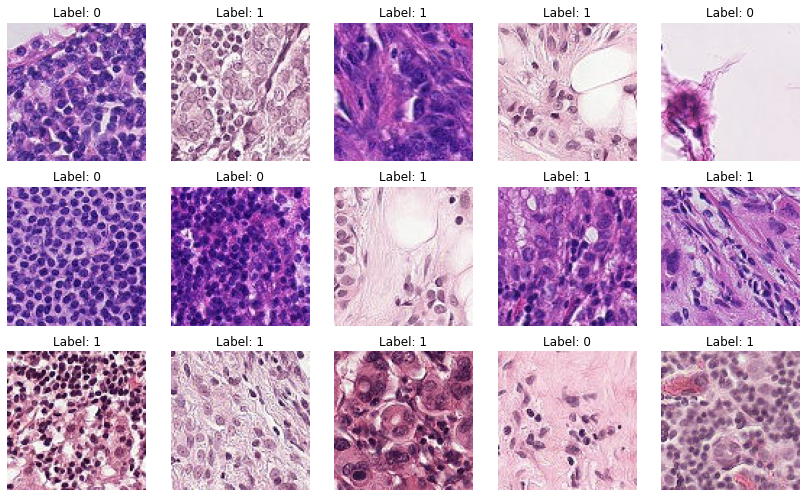

In [9]:
def preview_images(X, y, n, cols):
    sample_images = X[:n]
    sample_labels = y[:n]

    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(11.5, 7))

    for i, ax in enumerate(axs.flatten()):
        image = sample_images[i]
        label = sample_labels[i]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")

    plt.tight_layout()


preview_images(X, y, 15, 5)

## Shuffle and Split Dataset

In [10]:
from sklearn.model_selection import train_test_split

X_numpy = X[:]
y_numpy = y[:]

X_train, X_test, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=1000, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2000, random_state=1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11000, 96, 96, 3)
(2000, 96, 96, 3)
(1000, 96, 96, 3)


## Convert Splits to RecordIO Format

In [ ]:
def write_to_recordio(X: np.ndarray, y: np.ndarray, prefix: str):
    record = mx.recordio.MXIndexedRecordIO(idx_path=f"{prefix}.idx", uri=f"{prefix}.rec", flag="w")
    for idx, arr in enumerate(tqdm(X)):
        header = mx.recordio.IRHeader(0, y[idx], idx, 0)
        s = mx.recordio.pack_img(
            header,
            arr,
            quality=95,
            img_fmt=".jpg",
        )
        record.write_idx(idx, s)
    record.close()

In [ ]:
write_to_recordio(X_train, y_train, prefix="data/train")
write_to_recordio(X_val, y_val, prefix="data/val")
write_to_recordio(X_test, y_test, prefix="data/test")

## Upload Data Splits to S3

In [ ]:
prefix = "cv-metastasis"

try:
    s3_client.create_bucket(
        Bucket=bucket, ACL="private", CreateBucketConfiguration={"LocationConstraint": region}
    )
    print(f"Created S3 bucket: {bucket}")

except Exception as e:
    if e.response["Error"]["Code"] == "BucketAlreadyOwnedByYou":
        print(f"Using existing bucket: {bucket}")
    else:
        raise (e)

In [ ]:
%store prefix

In [ ]:
s3_client.upload_file("data/train.rec", bucket, f"{prefix}/data/train/train.rec")
s3_client.upload_file("data/val.rec", bucket, f"{prefix}/data/val/val.rec")
s3_client.upload_file("data/test.rec", bucket, f"{prefix}/data/test/test.rec")

## Configure the Estimator

In [ ]:
training_image = sagemaker.image_uris.retrieve("image-classification", region)
num_training_samples = X_train.shape[0]
num_classes = len(np.unique(y_train))

hyperparameters = {
    "num_layers": 18,
    "use_pretrained_model": 1,
    "augmentation_type": "crop_color_transform",
    "image_shape": "3,96,96",
    "num_classes": num_classes,
    "num_training_samples": num_training_samples,
    "mini_batch_size": 64,
    "epochs": 5,
    "learning_rate": 0.01,
    "precision_dtype": "float32",
}

estimator_config = {
    "hyperparameters": hyperparameters,
    "image_uri": training_image,
    "role": sagemaker.get_execution_role(),
    "instance_count": 1,
    "instance_type": "ml.p3.2xlarge",
    "volume_size": 100,
    "max_run": 360000,
    "output_path": f"s3://{bucket}/{prefix}/training_jobs",
}

image_classifier = sagemaker.estimator.Estimator(**estimator_config)

In [ ]:
%store num_training_samples

## Configure the Hyperparameter Tuner

Although we would prefer to tune for recall, the current HyperparameterTuner implementation for Image Classification only supports validation accuracy.

In [ ]:
hyperparameter_ranges = {
    "mini_batch_size": sagemaker.parameter.CategoricalParameter([16, 32, 64]),
    "learning_rate": sagemaker.parameter.CategoricalParameter([0.001, 0.01]),
}

hyperparameter_tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=image_classifier,
    objective_metric_name="validation:accuracy",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=2,
    base_tuning_job_name=prefix,
)

## Define the Data Channels

In [ ]:
train_input = sagemaker.inputs.TrainingInput(
    s3_data=f"s3://{bucket}/{prefix}/data/train",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
    input_mode="Pipe",
)

val_input = sagemaker.inputs.TrainingInput(
    s3_data=f"s3://{bucket}/{prefix}/data/val",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
    input_mode="Pipe",
)

data_channels = {"train": train_input, "validation": val_input}

## Run Hyperparameter Tuning Jobs

In [ ]:
if 'tuning_job_name' not in locals():
    hyperparameter_tuner.fit(inputs=data_channels)
    tuning_job_name = hyperparameter_tuner.describe().get('HyperParameterTuningJobName')
    %store tuning_job_name
else:
    print(f'Using previous tuning job: {tuning_job_name}')

In [ ]:
%store tuning_job_name

## Examine Results

<div class="alert alert-warning">
<b>NOTE:</b> If your kernel has restarted after running the hyperparameter tuning job, everyting you need has been persisted to SageMaker. You can continue on without having to run the tuning job again.
</div>

In [22]:
results = sagemaker.analytics.HyperparameterTuningJobAnalytics(tuning_job_name)
results_df = results.dataframe()
results_df

,learning_rate,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.001,32.0,cv-metastasis-210506-2245-006-1885a581,Completed,0.871032,2021-05-06 22:59:35+00:00,2021-05-06 23:02:05+00:00,150.0
1,0.001,16.0,cv-metastasis-210506-2245-005-813c008b,Completed,0.859000,2021-05-06 22:59:47+00:00,2021-05-06 23:02:09+00:00,142.0
2,0.010,16.0,cv-metastasis-210506-2245-004-dff84c96,Completed,0.845500,2021-05-06 22:54:20+00:00,2021-05-06 22:56:44+00:00,144.0
3,0.010,64.0,cv-metastasis-210506-2245-003-c4900be7,Completed,0.880859,2021-05-06 22:54:32+00:00,2021-05-06 22:56:37+00:00,125.0
4,0.001,64.0,cv-metastasis-210506-2245-002-1178073c,Completed,0.857422,2021-05-06 22:49:20+00:00,2021-05-06 22:51:11+00:00,111.0
5,0.010,32.0,cv-metastasis-210506-2245-001-e67bb390,Completed,0.881448,2021-05-06 22:48:55+00:00,2021-05-06 22:51:03+00:00,128.0


In [ ]:
best_training_job_summary = results.description()["BestTrainingJob"]
best_training_job_name = best_training_job_summary["TrainingJobName"]

%store best_training_job_name